In [2]:
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
pd.set_option('display.max_colwidth', -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# Data Quality Assesment

In [3]:
dataset = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json', lines=True)
dataset.drop(['authors', 'link', 'date'], axis = 1, inplace = True) 
dataset.head()

,category,headline,short_description
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",She left her husband. He killed their children. Just another day in America.
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment."""


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   short_description  200853 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


In [5]:
dataset.describe()

,category,headline,short_description
count,200853,200853,200853
unique,41,199344,178353
top,POLITICS,Sunday Roundup,
freq,32739,90,19712


In [6]:
print("We have a total of {} categories".format(dataset['category'].nunique()))
dataset['category'].value_counts()

We have a total of 41 categories


POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL            9887 
STYLE & BEAUTY    9649 
PARENTING         8677 
HEALTHY LIVING    6694 
QUEER VOICES      6314 
FOOD & DRINK      6226 
BUSINESS          5937 
COMEDY            5175 
SPORTS            4884 
BLACK VOICES      4528 
HOME & LIVING     4195 
PARENTS           3955 
THE WORLDPOST     3664 
WEDDINGS          3651 
WOMEN             3490 
IMPACT            3459 
DIVORCE           3426 
CRIME             3405 
MEDIA             2815 
WEIRD NEWS        2670 
GREEN             2622 
WORLDPOST         2579 
RELIGION          2556 
STYLE             2254 
SCIENCE           2178 
WORLD NEWS        2177 
TASTE             2096 
TECH              2082 
MONEY             1707 
ARTS              1509 
FIFTY             1401 
GOOD NEWS         1398 
ARTS & CULTURE    1339 
ENVIRONMENT       1323 
COLLEGE           1144 
LATINO VOICES     1129 
CULTURE & ARTS    1030 
EDUCATION         1004 
Name: category, 

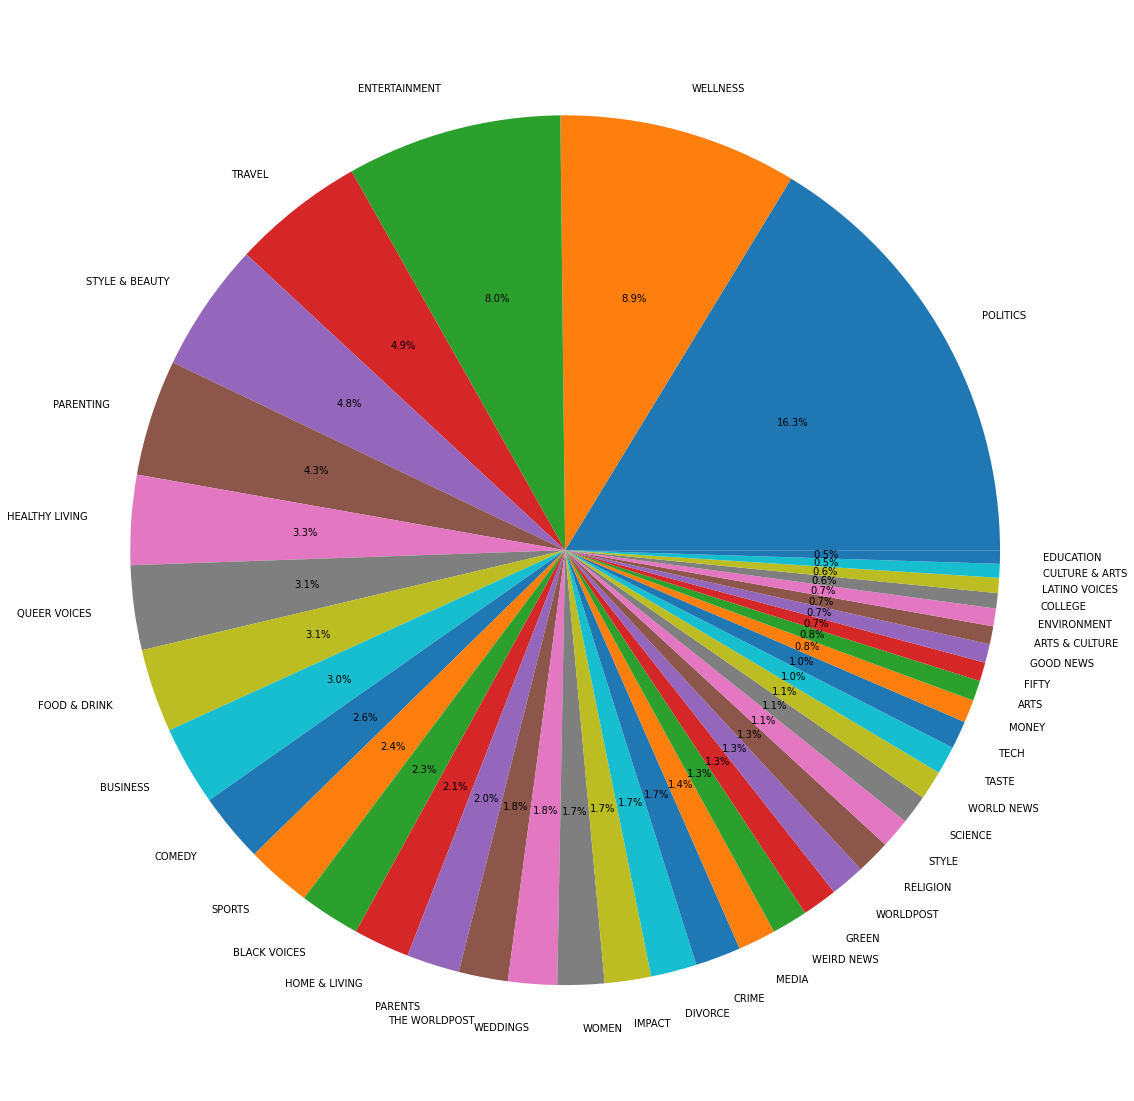

In [7]:
fig = plt.figure(figsize=(20,20))
plt.pie(dataset['category'].value_counts().values, 
        labels=dataset['category'].value_counts().index,
        autopct='%1.1f%%');

## Group the Categories

Let's try to group these categories and try to balance the dataset at the same time

In [8]:
categories = dataset['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            dataset.loc[dataset['category'] == ele, 'category'] = name

In [9]:
groupper( grouplist= ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'] , name =  'LIFESTYLE AND WELLNESS')

groupper( grouplist= [ 'PARENTING', 'PARENTS' ,'EDUCATION' ,'COLLEGE'] , name =  'PARENTING AND EDUCATION')

groupper( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','ARTS'] , name =  'SPORTS AND ENTERTAINMENT')

groupper( grouplist= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'TRAVEL-TOURISM & ART-CULTURE')

groupper( grouplist= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')

groupper( grouplist= ['BUSINESS' ,  'MONEY'] , name =  'BUSINESS-MONEY')

groupper( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

groupper( grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')

groupper( grouplist= ['TECH', 'SCIENCE'] , name =  'SCIENCE AND TECH')

groupper( grouplist= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','CRIME'] , name =  'GENERAL')

groupper( grouplist= ['WEDDINGS', 'DIVORCE',  'RELIGION','MEDIA'] , name =  'MISC')

In [10]:
print("We have a total of {} categories now".format(dataset['category'].nunique()))
dataset['category'].value_counts()

We have a total of 12 categories now


LIFESTYLE AND WELLNESS          40619
POLITICS                        32739
SPORTS AND ENTERTAINMENT        30296
TRAVEL-TOURISM & ART-CULTURE    20578
EMPOWERED VOICES                15461
PARENTING AND EDUCATION         14780
MISC                            12448
GENERAL                         9663 
WORLDNEWS                       8420 
BUSINESS-MONEY                  7644 
SCIENCE AND TECH                4260 
ENVIRONMENT                     3945 
Name: category, dtype: int64

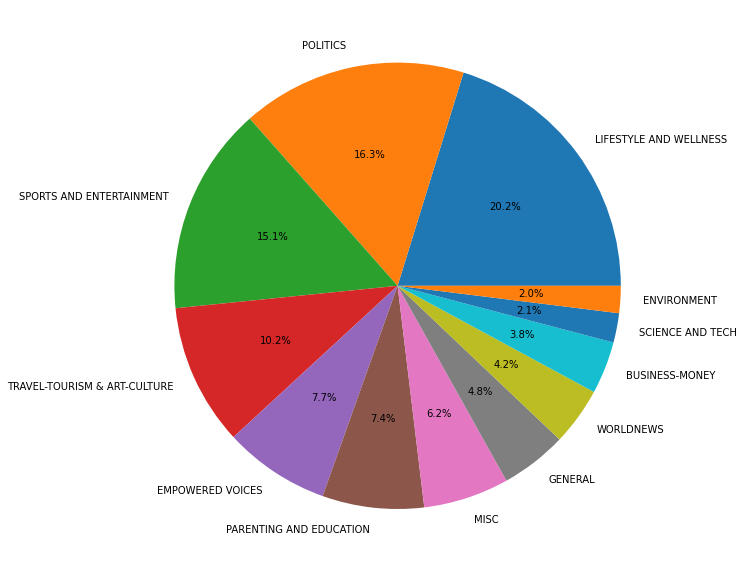

In [11]:
fig = plt.figure(figsize=(10,20))
plt.pie(dataset['category'].value_counts().values, 
        labels=dataset['category'].value_counts().index,
        autopct='%1.1f%%');

## Removing empty values and duplicates

### Duplicate Values

In [12]:
df = dataset.copy() #Let's create a copy of the data frame


In [13]:
df.duplicated().sum()  #total duplicates

473

In [14]:
df.drop_duplicates(keep='last', inplace=True) 

In [15]:
df.duplicated(subset=['short_description','headline']).sum() #duplicates under 'short_description' and 'headline'

15

In [16]:
df.drop_duplicates(subset=['short_description','headline'],keep='last',inplace=True)

### Empty Values

In [17]:
print(len(df[df['headline'] == ""]))

2


In [18]:
df.loc[df['headline'] == "", 'headline'] = np.nan
df.dropna(subset=['headline'], inplace=True)
print(len(df[df['headline'] == ""]))

0


In [19]:
print(len(df[df['short_description'] == ""]))


19610


In [20]:
df.loc[df['short_description'] == "", 'short_description'] = np.nan
df.dropna(subset=['short_description'], inplace=True)
print(len(df[df['short_description'] == ""]))

0


## Data Tidying

In [21]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 

In [22]:
df.head()

,category,headline,short_description
0,TRAVEL-TOURISM & ART-CULTURE,Outdoor Public Art to See Now (PHOTOS),"Explore 10 of the coolest outdoor public artworks on view now, from New York to Chicago to Seattle."
1,POLITICS,"U.S. Job Growth Rises Briskly, Wages Continue To Climb","U.S. economy adds more than expected 235,000 jobs in February, unemployment rate at 4.7 percent."
2,EMPOWERED VOICES,Transgender Man Proposes To Partner At White House LGBT Pride Reception,"WATCH the proposal (skip to 1:55): ""She's like, 'You see? It doesn't work,'' Scout interrupted. ""I'm like, 'Screw that.'"" WASHINGTON"
3,LIFESTYLE AND WELLNESS,I'm Not A Hoarder...But My Husband Is (PHOTOS),My husband and I first met in college. It wasn't until we moved in together four years later that I noticed that something was askew: I couldn't close his wardrobe drawers. His drawers were stuffed with endless amounts of t-shirts.
4,MISC,The Diamond Inside of Anxiety,"People find me because in the throes of anxiety. They're taken down by a series of questions that cause them to fear whether or not they're in the ""right"" relationship or if they're making a ""mistake."""


In [23]:
df['desc'] = df['headline'].astype(str)+"-"+df['short_description']
df.drop(columns =['headline','short_description'],axis = 1, inplace=True)
df.astype(str)
df.head()

,category,desc
0,TRAVEL-TOURISM & ART-CULTURE,"Outdoor Public Art to See Now (PHOTOS)-Explore 10 of the coolest outdoor public artworks on view now, from New York to Chicago to Seattle."
1,POLITICS,"U.S. Job Growth Rises Briskly, Wages Continue To Climb-U.S. economy adds more than expected 235,000 jobs in February, unemployment rate at 4.7 percent."
2,EMPOWERED VOICES,"Transgender Man Proposes To Partner At White House LGBT Pride Reception-WATCH the proposal (skip to 1:55): ""She's like, 'You see? It doesn't work,'' Scout interrupted. ""I'm like, 'Screw that.'"" WASHINGTON"
3,LIFESTYLE AND WELLNESS,I'm Not A Hoarder...But My Husband Is (PHOTOS)-My husband and I first met in college. It wasn't until we moved in together four years later that I noticed that something was askew: I couldn't close his wardrobe drawers. His drawers were stuffed with endless amounts of t-shirts.
4,MISC,"The Diamond Inside of Anxiety-People find me because in the throes of anxiety. They're taken down by a series of questions that cause them to fear whether or not they're in the ""right"" relationship or if they're making a ""mistake."""


# Tokenizing and Padding

In [68]:
X,Y = df['desc'],df['category']

#80% to train , 10% for validation , 10% for testing
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state=42)

In [25]:
vocab_size =20000
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [26]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_train = np.asarray(y_train)
y_train = pd.get_dummies(y_train)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1)   #this would be our ground truth label while testing

print(train_set.shape)
print(train_label.shape)


print(val_set.shape)
print(val_label.shape)




(144602, 150)
(144602, 12)
(18075, 150)
(18075, 12)


# Embedding Matrix for our model

In [28]:
!wget http://nlp.stanford.edu/data/glove.6B.zip #downloadingu glove vec word embeddings


--2021-01-08 04:41:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-08 04:41:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-08 04:41:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [29]:
!unzip -q glove.6B.zip #unzipping 

In [30]:
path_to_glove_file =  './glove.6B.100d.txt'

In [31]:
#Initialising the embedding matrix with glove vec embeddings

num_tokens = len(tokenizer.word_index.items()) + 2
embedding_dim = 100
hits = 0
misses = 0


embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 65327 words (37563 misses)


# Model Training

In [133]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=3, min_delta=0.0001)


tf.keras.backend.clear_session()
embed_size = 100
model = keras.models.Sequential([
                                 
        Embedding(num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        mask_zero=True,input_shape=[None],trainable=False),
        keras.layers.Bidirectional(keras.layers.LSTM(256, dropout = 0.4)),
        keras.layers.Dense(12, activation="softmax")
            
        ])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         10289200  
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               731136    
_________________________________________________________________
dense (Dense)                (None, 12)                6156      
Total params: 11,026,492
Trainable params: 737,292
Non-trainable params: 10,289,200
_________________________________________________________________


In [134]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit( train_set,train_label,
                     batch_size = 32,
                     steps_per_epoch=len(X_train) // 32, 
                     validation_data = (val_set , val_label),
                     validation_steps = len(val_set)//32, epochs=20,
                     callbacks=  early_stop )

Epoch 1/20
4518/4518 [==============================] - 82s 18ms/step - loss: 1.1688 - accuracy: 0.6244 - val_loss: 0.9925 - val_accuracy: 0.6825
Epoch 2/20
4518/4518 [==============================] - 80s 18ms/step - loss: 0.9761 - accuracy: 0.6831 - val_loss: 0.9096 - val_accuracy: 0.7087
Epoch 3/20
4518/4518 [==============================] - 80s 18ms/step - loss: 0.9071 - accuracy: 0.7048 - val_loss: 0.8869 - val_accuracy: 0.7138
Epoch 4/20
4518/4518 [==============================] - 79s 17ms/step - loss: 0.8587 - accuracy: 0.7192 - val_loss: 0.8796 - val_accuracy: 0.7164
Epoch 5/20
4518/4518 [==============================] - 80s 18ms/step - loss: 0.8214 - accuracy: 0.7299 - val_loss: 0.8777 - val_accuracy: 0.7159
Epoch 6/20
4518/4518 [==============================] - 79s 18ms/step - loss: 0.7895 - accuracy: 0.7387 - val_loss: 0.8760 - val_accuracy: 0.7227
Epoch 7/20
4518/4518 [==============================] - 78s 17ms/step - loss: 0.7644 - accuracy: 0.7476 - val_loss: 0.8776 -

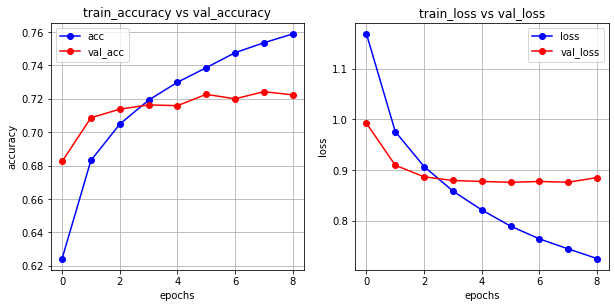

In [135]:
 fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


# Evaluating and Making Predictions

In [104]:
classes = dataset['category'].value_counts().index

def prediction(inference_data):
    X = tokenizer.texts_to_sequences(inference_data)
    X = pad_sequences(X,maxlen= max_length,padding=padding_type, truncating=trunc_type)
    pred = model.predict(X)
    pred_value = tf.argmax(pred,axis =1).numpy()                
    return pred_value

              precision    recall  f1-score   support

           0       0.67      0.53      0.59       709
           1       0.60      0.52      0.55      1309
           2       0.63      0.50      0.56       347
           3       0.59      0.28      0.38       796
           4       0.77      0.84      0.81      3890
           5       0.68      0.74      0.71      1108
           6       0.69      0.73      0.71      1427
           7       0.76      0.80      0.78      2865
           8       0.58      0.52      0.55       372
           9       0.69      0.75      0.71      2560
          10       0.80      0.80      0.80      1958
          11       0.74      0.71      0.72       735

    accuracy                           0.72     18076
   macro avg       0.68      0.64      0.66     18076
weighted avg       0.72      0.72      0.72     18076



Text(0.5, 1.0, 'Confusion matrix of model')

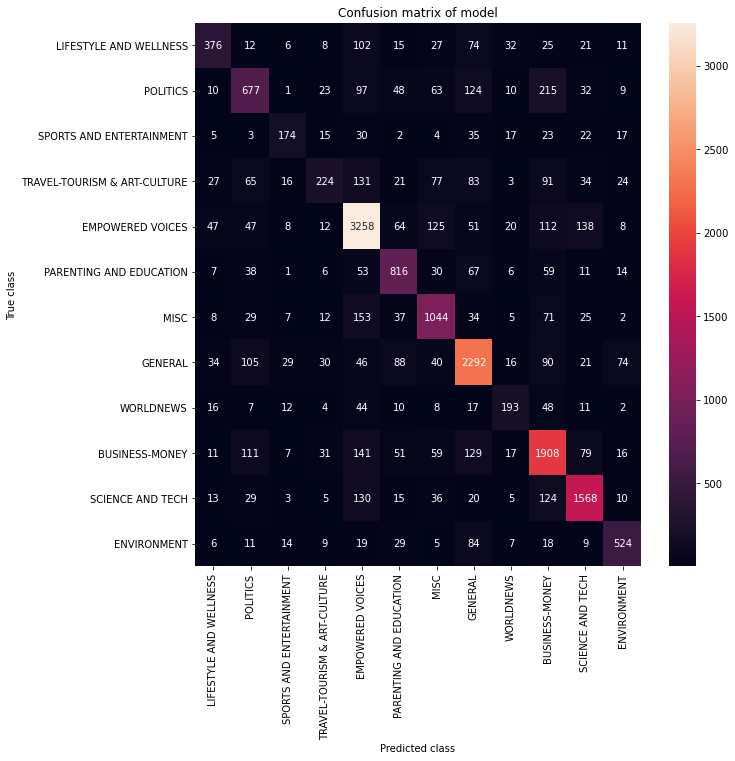

In [105]:
y_pred = prediction(X_test)
print(classification_report(np.asarray(y_test),np.asarray( y_pred)))
cf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=classes,
                      yticklabels=classes,
                      annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

This is definitely not the best model as it performs well on certain classes only but adding more data to the classes with less data and groupping the data efficiently will improve the accuracy and specificity of the model significantly.

Let me know if I can help you understand from the notebook! 
Have a great day!